# PyXcorrDIA Preprocessing Analysis

This notebook analyzes all the XCorr preprocessing steps in pyXcorrDIA to understand how Comet's algorithm transforms the experimental spectrum. We'll visualize each step to debug why XCorr scores are higher than expected.

## Comet's Preprocessing Pipeline:
1. **Binning**: Convert peaks to unit mass bins using BIN macro with 0.4 offset
2. **Square Root Transform**: Apply sqrt(intensity) to all binned intensities  
3. **MakeCorrData Windowing**: Divide spectrum into 10 windows, normalize each to 50.0
4. **Fast XCorr Preprocessing**: Sliding window (offset=75) to calculate local averages
5. **XCorr Calculation**: Dot product with theoretical spectrum, scaled by 0.005

**Configuration**: You can choose which spectrum to analyze by changing the `TARGET_SPECTRUM` variable:
- Set to a specific scan ID (e.g., 36889) to analyze that spectrum
- Set to `None` or `'first'` to use the first MS2 spectrum  
- Set to `'random'` to pick a random spectrum from the file

**Key Question**: Why are our XCorr scores still 5-20x higher than typical Comet values (1-5 range)?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to path to import pyXcorrDIA
sys.path.append('.')
from pyXcorrDIA import FastXCorr, MassSpectrum, PeptideCandidate

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Imports successful!")

# Create a FastXCorr instance to show its properties
xcorr_test = FastXCorr()
print(f"FastXCorr class loaded with:")

# Safely display attributes that should exist
try:
    print(f"  - Bin width: {xcorr_test.bin_width}")
except AttributeError:
    print("  - Bin width: Not available")

try:
    print(f"  - Mass range: {xcorr_test.mass_range}")
except AttributeError:
    print("  - Mass range: Not available")

try:
    print(f"  - Number of bins: {xcorr_test.num_bins}")
except AttributeError:
    print("  - Number of bins: Not available")

# Check for BIN macro parameters
try:
    print(f"  - Inverse bin width: {xcorr_test.inverse_bin_width}")
except AttributeError:
    print("  - Inverse bin width: Not available (calculated as 1.0/bin_width)")

try:
    print(f"  - BIN offset: {xcorr_test.bin_offset}")
except AttributeError:
    print("  - BIN offset: Not available (hardcoded as 0.4)")

print("Ready to analyze XCorr preprocessing steps!")

Imports successful!
FastXCorr class loaded with:
  - Bin width: 1.0005079
  - Mass range: (0, 2000)
  - Number of bins: 1999
  - Inverse bin width: 0.9994923578314575
  - BIN offset: 0.4
Ready to analyze XCorr preprocessing steps!


In [3]:
# Initialize the XCorr engine and read the spectrum
xcorr_engine = FastXCorr()

# CONFIGURATION: Set which spectrum to analyze
# Options:
#   - Set to a specific scan ID (e.g., 36889) to analyze that spectrum
#   - Set to None or 'first' to use the first MS2 spectrum
#   - Set to 'random' to pick a random spectrum
TARGET_SPECTRUM = 14520  # Change this value to analyze different spectra

# PLOTTING CONFIGURATION: Set m/z range for plots
# Options:
#   - Set to None to use the full m/z range of the spectrum (dynamic)
#   - Set to [min_mz, max_mz] to use a custom range (e.g., [300, 1500])
PLOT_MZ_RANGE = None  # Change to [300, 1500] for fixed range, or None for dynamic

# Read mzML file
mzml_file = 'Ste-2025-01-08_I_1Th_GPFDIA_400-500_15m_015.mzML'
print(f"Reading {mzml_file}...")

if TARGET_SPECTRUM is None or TARGET_SPECTRUM == 'first':
    print("Using first MS2 spectrum...")
    spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=1)
elif TARGET_SPECTRUM == 'random':
    print("Loading all spectra to pick a random one...")
    all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)  # Use -1 instead of None
    if all_spectra:
        import random
        spectrum = random.choice(all_spectra)
        print(f"Randomly selected spectrum {spectrum.scan_id}")
        spectra = [spectrum]
    else:
        spectra = []
else:
    # Use fast single spectrum lookup for specific scan IDs
    print(f"Using fast lookup for spectrum {TARGET_SPECTRUM}...")
    try:
        spectrum = xcorr_engine.read_single_spectrum(mzml_file, str(TARGET_SPECTRUM))
        print(f"✓ Successfully loaded spectrum {TARGET_SPECTRUM} using fast mzML index lookup!")
        spectra = [spectrum]
    except ValueError as e:
        print(f"❌ Fast lookup failed: {e}")
        print("Falling back to sequential search...")
        all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)
        
        # Find the target spectrum
        target_spectrum = None
        for spec in all_spectra:
            if spec.scan_id == str(TARGET_SPECTRUM):
                target_spectrum = spec
                break
        
        if target_spectrum is None:
            print(f"Spectrum {TARGET_SPECTRUM} not found!")
            print(f"Available scan IDs (first 20): {[s.scan_id for s in all_spectra[:20]]}")
            if len(all_spectra) > 20:
                print(f"... and {len(all_spectra) - 20} more spectra")
            print("Using first spectrum as fallback...")
            spectra = [all_spectra[0]] if all_spectra else []
        else:
            print(f"Found spectrum {TARGET_SPECTRUM} via sequential search!")
            spectra = [target_spectrum]

if not spectra:
    print("No spectra found!")
else:
    spectrum = spectra[0]
    
    # Determine plot range
    if PLOT_MZ_RANGE is None:
        # Use dynamic range based on actual data
        plot_min_mz = spectrum.mz_array.min()
        plot_max_mz = spectrum.mz_array.max()
        print(f"Using dynamic m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    else:
        # Use custom range
        plot_min_mz, plot_max_mz = PLOT_MZ_RANGE
        print(f"Using custom m/z range: {plot_min_mz} - {plot_max_mz}")
    
    print(f"\n=== SELECTED SPECTRUM ===")
    print(f"Scan ID: {spectrum.scan_id}")
    print(f"Precursor m/z: {spectrum.precursor_mz:.4f}")
    print(f"Charge: {spectrum.charge}")
    print(f"Isolation window: [{spectrum.isolation_window_lower:.5f}-{spectrum.isolation_window_upper:.5f}]")
    print(f"Number of peaks: {len(spectrum.mz_array)}")
    print(f"m/z range: {spectrum.mz_array.min():.2f} - {spectrum.mz_array.max():.2f}")
    print(f"Intensity range: {spectrum.intensity_array.min():.0f} - {spectrum.intensity_array.max():.0f}")
    print(f"Plot m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    print("=========================")

Reading Ste-2025-01-08_I_1Th_GPFDIA_400-500_15m_015.mzML...
Using fast lookup for spectrum 14520...
✓ Successfully loaded spectrum 14520 using fast mzML index lookup!
Using dynamic m/z range: 200.4 - 1499.7

=== SELECTED SPECTRUM ===
Scan ID: 14520
Precursor m/z: 475.9662
Charge: 2
Isolation window: [475.46619-476.46619]
Number of peaks: 934
m/z range: 200.42 - 1499.67
Intensity range: 65 - 203065
Plot m/z range: 200.4 - 1499.7


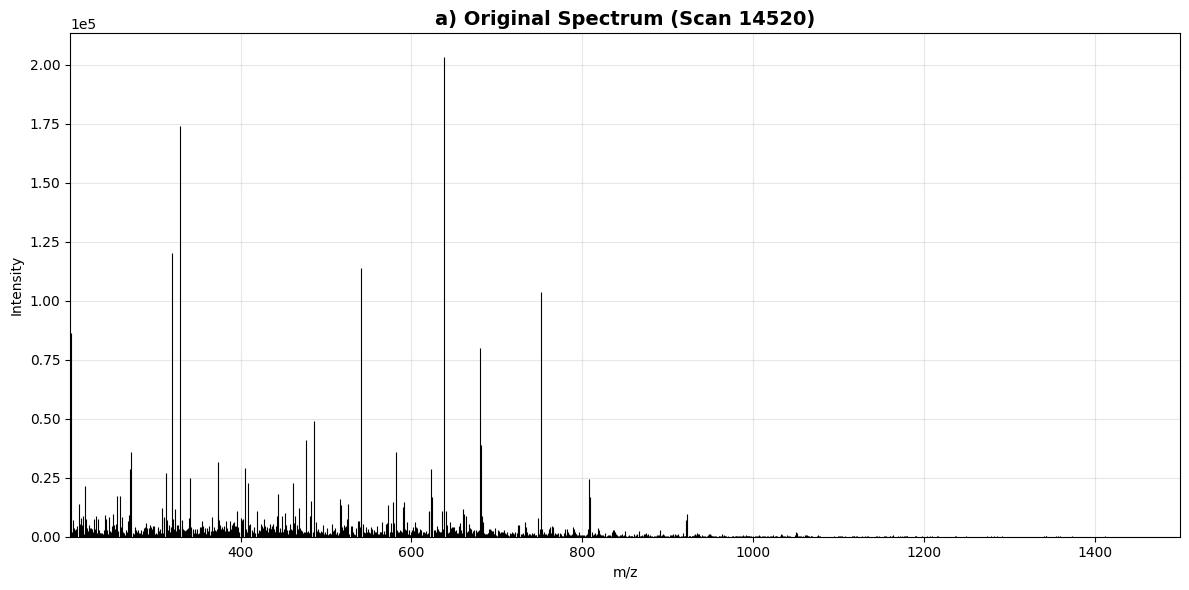

Original spectrum stats:
  Number of peaks: 934
  Max intensity: 203065
  Mean intensity: 3736
  Plot range: 200.4 - 1499.7 m/z


In [4]:
# Step 1: Plot the original raw spectrum
plt.figure(figsize=(12, 6))
plt.vlines(spectrum.mz_array, 0, spectrum.intensity_array, colors='k', linewidth=0.8)
plt.title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontsize=14, fontweight='bold')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)
plt.ylim(0, None)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

print(f"Original spectrum stats:")
print(f"  Number of peaks: {len(spectrum.mz_array)}")
print(f"  Max intensity: {spectrum.intensity_array.max():.0f}")
print(f"  Mean intensity: {spectrum.intensity_array.mean():.0f}")
print(f"  Plot range: {plot_min_mz:.1f} - {plot_max_mz:.1f} m/z")

=== COMPREHENSIVE PROCESSING ANALYSIS ===
Analyzing spectrum: 14520
Precursor m/z: 475.9662
Original peaks: 934

--- PROCESSING STEPS ---
1. Original: 934 peaks, max intensity: 203065
2. Binning into 1 Da bins with square root transform...
   Processed 934 peaks into 836 bins
   Max binned intensity: 450.63
   Highest ion bin: 1499
3. Applying MakeCorrData windowing (10 windows, normalize to 50.0)...
   Windowed spectrum max: 50.00
   Non-zero windowed bins: 646
4. Applying Fast XCorr preprocessing (sliding window offset=75)...
   Preprocessed range: [-11.313, 73.781]
   Preprocessed mean: -0.000000


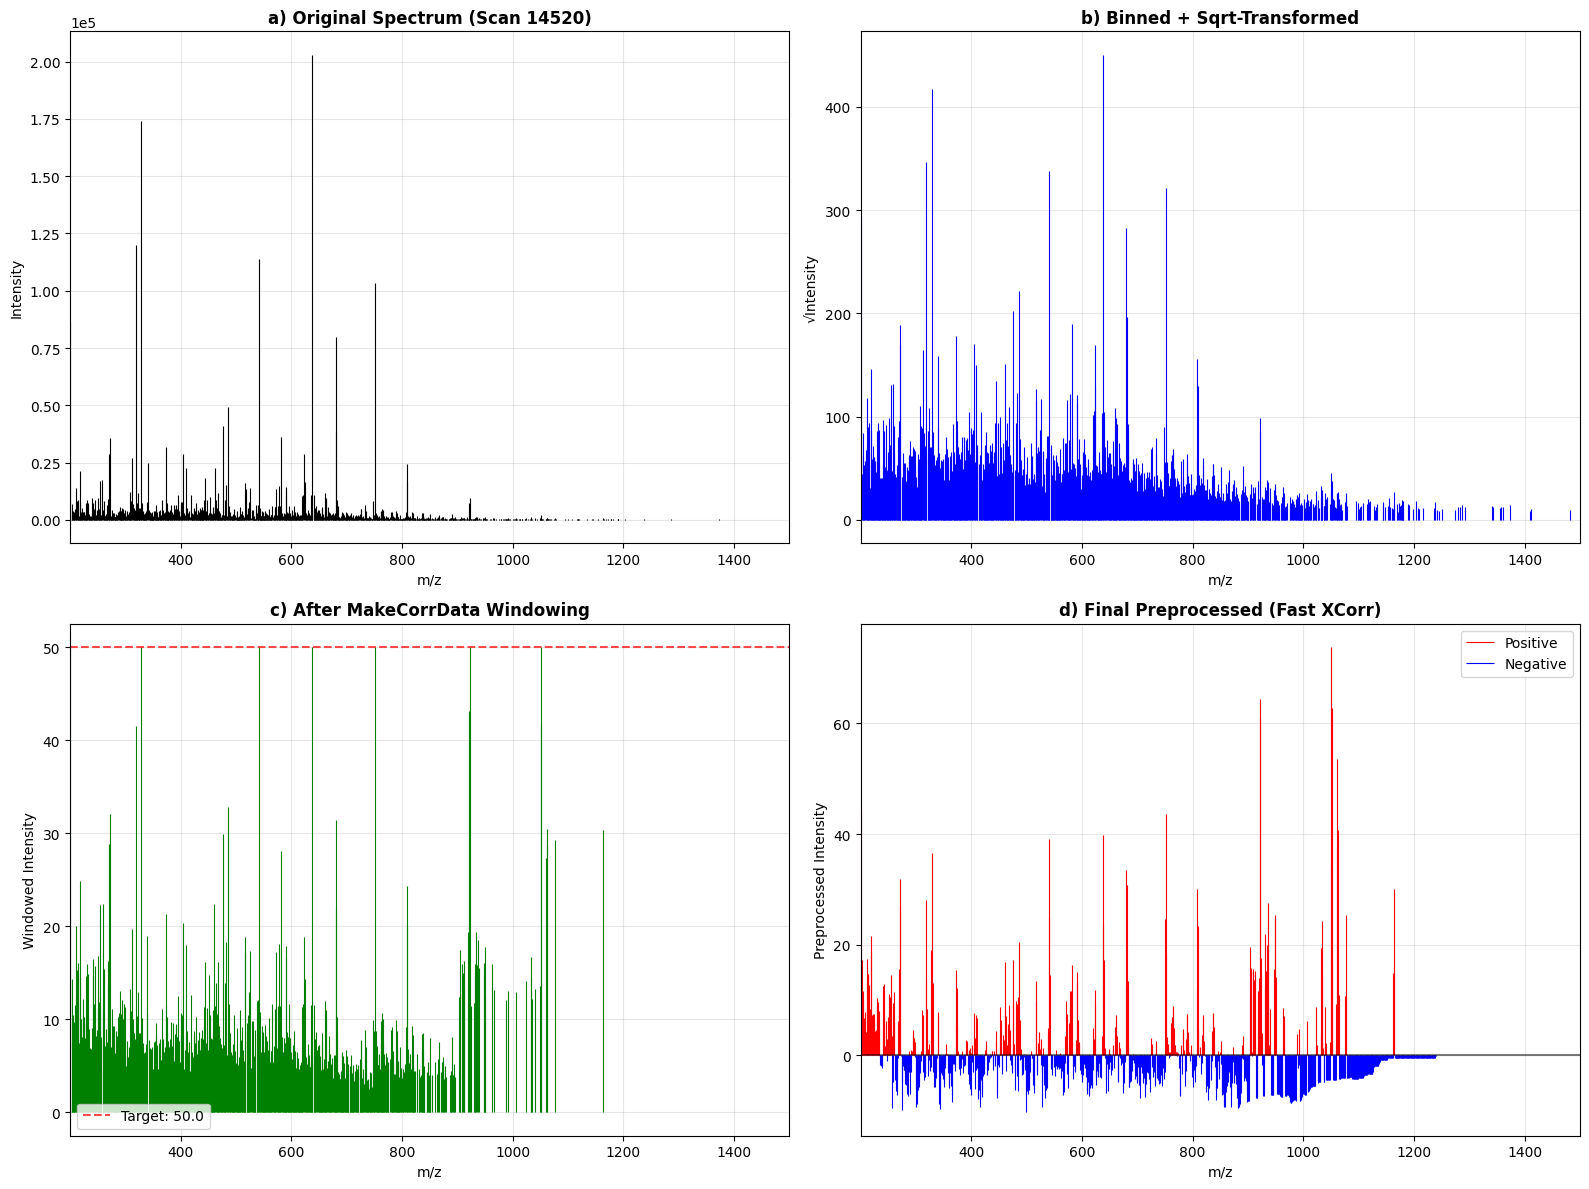


--- PROCESSING SUMMARY ---
Original peaks: 934
After binning: 836 bins
After windowing: 646 bins
Final preprocessed: 1999 bins
Intensity reduction: 203065 → 450.6 → 50.0
Processing complete!


In [6]:
# COMPREHENSIVE SPECTRUM PROCESSING ANALYSIS FOR SPECTRUM 36889
print("=== COMPREHENSIVE PROCESSING ANALYSIS ===")
print(f"Analyzing spectrum: {spectrum.scan_id}")
print(f"Precursor m/z: {spectrum.precursor_mz:.4f}")
print(f"Original peaks: {len(spectrum.mz_array)}")

# Import pyXcorrDIA module properly
import sys
import os
sys.path.append('.')
import pyXcorrDIA

# Reload the module to pick up any changes (no peak filtering)
import importlib
importlib.reload(pyXcorrDIA)

# Create fresh XCorr processor
xcorr_engine = pyXcorrDIA.FastXCorr()

# Step-by-step processing visualization
print("\n--- PROCESSING STEPS ---")

# Step 1: Original spectrum (no changes)
original_mz = spectrum.mz_array.copy()
original_intensity = spectrum.intensity_array.copy()
print(f"1. Original: {len(original_mz)} peaks, max intensity: {original_intensity.max():.0f}")

# Step 2: Binning with square root transform
print("2. Binning into 1 Da bins with square root transform...")
binned_spectrum = np.zeros(xcorr_engine.num_bins)
bin_width = xcorr_engine.bin_width
min_mz = xcorr_engine.mass_range[0]
max_mz = xcorr_engine.mass_range[1]

# Create m/z array for binned spectrum
mz_binned = np.arange(min_mz, min_mz + len(binned_spectrum) * bin_width, bin_width)[:len(binned_spectrum)]

# Bin the spectrum manually to see each step
highest_intensity = 0.0
highest_ion_bin = 0
peak_count = 0

for mz, intensity in zip(original_mz, original_intensity):
    if min_mz <= mz <= max_mz:
        peak_count += 1
        # Apply square root transformation
        sqrt_intensity = np.sqrt(intensity)
        # Bin using Comet's BIN macro
        bin_idx = xcorr_engine.bin_mass(mz)
        relative_bin_idx = bin_idx - xcorr_engine.bin_mass(min_mz)
        
        if 0 <= relative_bin_idx < len(binned_spectrum):
            binned_spectrum[relative_bin_idx] = max(binned_spectrum[relative_bin_idx], sqrt_intensity)
            if binned_spectrum[relative_bin_idx] > highest_intensity:
                highest_intensity = binned_spectrum[relative_bin_idx]
            # Track the highest bin index that contains any data
            if binned_spectrum[relative_bin_idx] > 0:
                highest_ion_bin = max(highest_ion_bin, relative_bin_idx)

print(f"   Processed {peak_count} peaks into {np.count_nonzero(binned_spectrum)} bins")
print(f"   Max binned intensity: {highest_intensity:.2f}")
print(f"   Highest ion bin: {highest_ion_bin}")

# Step 3: MakeCorrData windowing normalization
print("3. Applying MakeCorrData windowing (10 windows, normalize to 50.0)...")
windowed_spectrum = xcorr_engine._make_corr_data(binned_spectrum, highest_ion_bin, highest_intensity)
print(f"   Windowed spectrum max: {windowed_spectrum.max():.2f}")
print(f"   Non-zero windowed bins: {np.count_nonzero(windowed_spectrum)}")

# Step 4: Fast XCorr preprocessing  
print("4. Applying Fast XCorr preprocessing (sliding window offset=75)...")
preprocessed_spectrum = xcorr_engine.preprocess_for_xcorr(windowed_spectrum)
print(f"   Preprocessed range: [{preprocessed_spectrum.min():.3f}, {preprocessed_spectrum.max():.3f}]")
print(f"   Preprocessed mean: {preprocessed_spectrum.mean():.6f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot a) Original spectrum
ax1 = axes[0, 0]
mask_orig = (original_mz >= plot_min_mz) & (original_mz <= plot_max_mz)
ax1.vlines(original_mz[mask_orig], 0, original_intensity[mask_orig], colors='k', linewidth=0.8)
ax1.set_title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontweight='bold', fontsize=12)
ax1.set_xlabel('m/z')
ax1.set_ylabel('Intensity')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(plot_min_mz, plot_max_mz)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot b) Binned + sqrt spectrum
ax2 = axes[0, 1]
mask_bin = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (binned_spectrum > 0)
ax2.vlines(mz_binned[mask_bin], 0, binned_spectrum[mask_bin], colors='b', linewidth=0.8)
ax2.set_title('b) Binned + Sqrt-Transformed', fontweight='bold', fontsize=12)
ax2.set_xlabel('m/z')
ax2.set_ylabel('√Intensity')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(plot_min_mz, plot_max_mz)

# Plot c) Windowed spectrum (MakeCorrData output)
ax3 = axes[1, 0]
mask_win = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (windowed_spectrum > 0)
ax3.vlines(mz_binned[mask_win], 0, windowed_spectrum[mask_win], colors='g', linewidth=0.8)
ax3.set_title('c) After MakeCorrData Windowing', fontweight='bold', fontsize=12)
ax3.set_xlabel('m/z')
ax3.set_ylabel('Windowed Intensity')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(plot_min_mz, plot_max_mz)
ax3.axhline(y=50.0, color='r', linestyle='--', alpha=0.7, label='Target: 50.0')
ax3.legend()

# Plot d) Final preprocessed spectrum (can have negative values) - use stem plot like Comet paper
ax4 = axes[1, 1]
mask_prep = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
# Separate positive and negative values for better visualization
positive_mask = mask_prep & (preprocessed_spectrum > 0)
negative_mask = mask_prep & (preprocessed_spectrum < 0)
# Plot positive values in red, negative in blue
if np.any(positive_mask):
    ax4.vlines(mz_binned[positive_mask], 0, preprocessed_spectrum[positive_mask], 
               colors='r', linewidth=0.8, label='Positive')
if np.any(negative_mask):
    ax4.vlines(mz_binned[negative_mask], 0, preprocessed_spectrum[negative_mask], 
               colors='b', linewidth=0.8, label='Negative')
ax4.set_title('d) Final Preprocessed (Fast XCorr)', fontweight='bold', fontsize=12)
ax4.set_xlabel('m/z')
ax4.set_ylabel('Preprocessed Intensity')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(plot_min_mz, plot_max_mz)
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.5)
if np.any(positive_mask) or np.any(negative_mask):
    ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n--- PROCESSING SUMMARY ---")
print(f"Original peaks: {len(original_mz)}")
print(f"After binning: {np.count_nonzero(binned_spectrum)} bins")
print(f"After windowing: {np.count_nonzero(windowed_spectrum)} bins")
print(f"Final preprocessed: {len(preprocessed_spectrum)} bins")
print(f"Intensity reduction: {original_intensity.max():.0f} → {highest_intensity:.1f} → {windowed_spectrum.max():.1f}")
print(f"Processing complete!")

# Store results for further analysis
spectrum.binned_spectrum = binned_spectrum
spectrum.windowed_spectrum = windowed_spectrum  
spectrum.preprocessed_spectrum = preprocessed_spectrum

=== FAST XCORR PREPROCESSING ANALYSIS ===
Fast XCorr preprocessing parameters:
  XCorr offset: 75
  Window range: 151 bins
  Normalization factor: 0.006667
  Formula: y'[i] = y[i] - (sum of y[i-75:i+75] excluding y[i]) / 150

Preprocessing transformation results:
  Input (windowed) range: [0, 50.00]
  Output (preprocessed) range: [-11.313, 73.781]
  Preprocessed mean: -0.000000 (should be ≈ 0)
  Preprocessed std: 6.3844

Value distribution after preprocessing:
  Positive values: 341 (17.1%)
  Negative values: 1534 (76.7%)
  Zero values: 124 (6.2%)
  Positive range: [0.029, 73.781]
  Negative range: [-11.313, -0.000]

Specific transformation examples:
  High intensity regions (windowed > 40):
    m/z  201.1:  50.00 →  44.1193
    m/z  319.2:  41.53 →  28.0552
    m/z  329.2:  50.00 →  36.5864
    m/z  541.3:  50.00 →  39.1854
    m/z  638.3:  50.00 →  39.7611


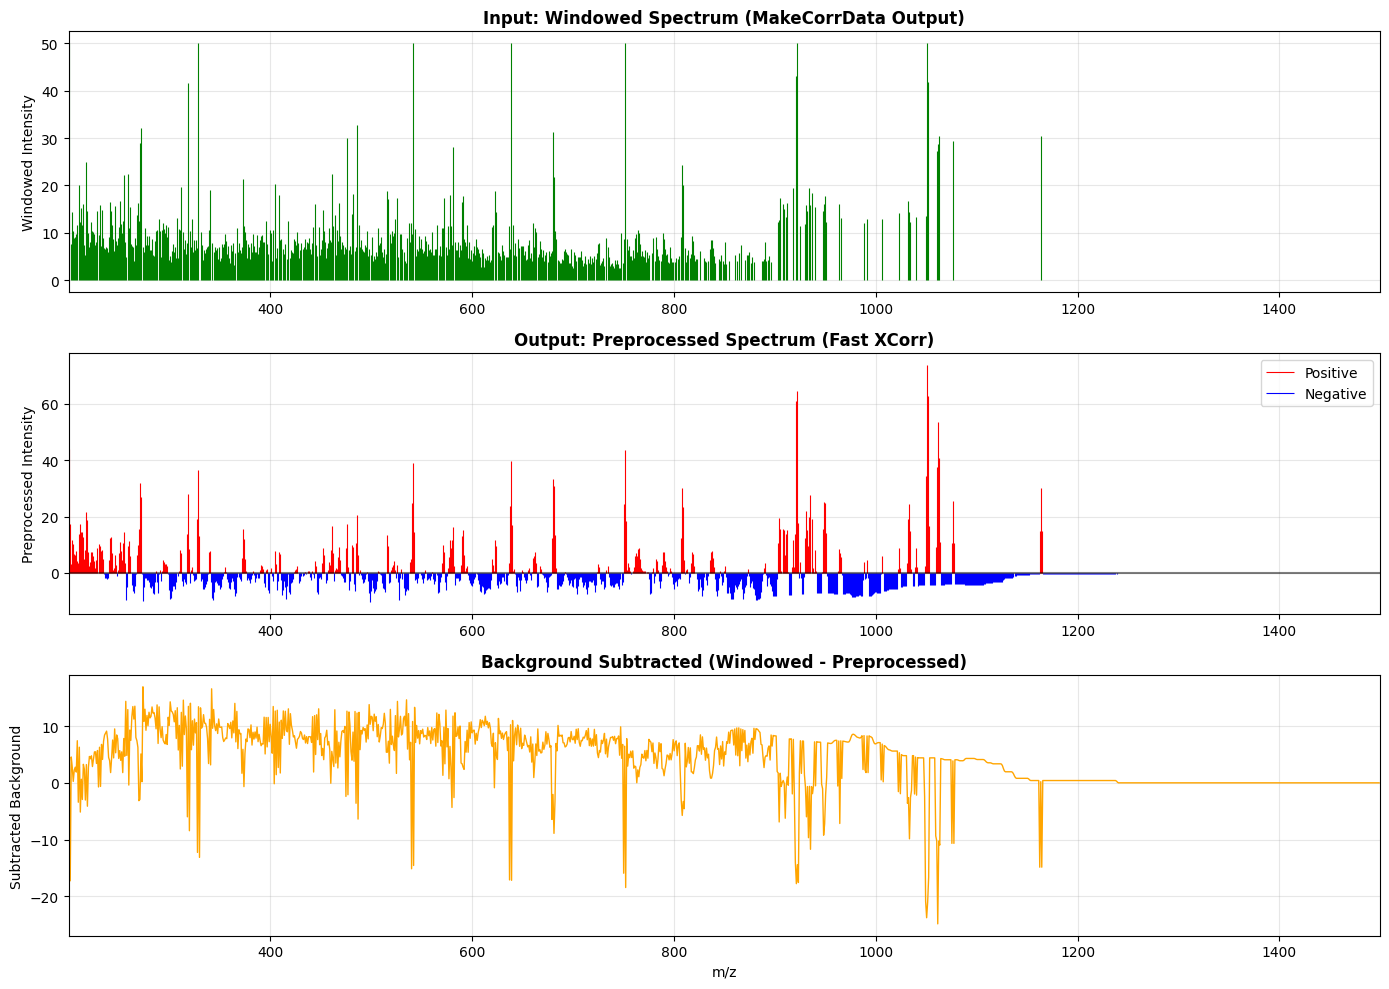


Fast XCorr preprocessing complete!
The preprocessed spectrum is now ready for XCorr calculation with theoretical spectra.


In [10]:
# FAST XCORR PREPROCESSING ANALYSIS
print("=== FAST XCORR PREPROCESSING ANALYSIS ===")

# The preprocessing has already been done in the comprehensive analysis above
# Let's analyze the results in detail

print(f"Fast XCorr preprocessing parameters:")
xcorr_offset = 75
window_range = 2 * xcorr_offset + 1
normalization_factor = 1.0 / (window_range - 1.0)

print(f"  XCorr offset: {xcorr_offset}")
print(f"  Window range: {window_range} bins")
print(f"  Normalization factor: {normalization_factor:.6f}")
print(f"  Formula: y'[i] = y[i] - (sum of y[i-75:i+75] excluding y[i]) / 150")

print(f"\nPreprocessing transformation results:")
print(f"  Input (windowed) range: [0, {windowed_spectrum.max():.2f}]")
print(f"  Output (preprocessed) range: [{preprocessed_spectrum.min():.3f}, {preprocessed_spectrum.max():.3f}]")
print(f"  Preprocessed mean: {preprocessed_spectrum.mean():.6f} (should be ≈ 0)")
print(f"  Preprocessed std: {preprocessed_spectrum.std():.4f}")

# Analyze the preprocessing effect
positive_values = preprocessed_spectrum[preprocessed_spectrum > 0]
negative_values = preprocessed_spectrum[preprocessed_spectrum < 0]
zero_values = preprocessed_spectrum[preprocessed_spectrum == 0]

print(f"\nValue distribution after preprocessing:")
print(f"  Positive values: {len(positive_values)} ({len(positive_values)/len(preprocessed_spectrum)*100:.1f}%)")
print(f"  Negative values: {len(negative_values)} ({len(negative_values)/len(preprocessed_spectrum)*100:.1f}%)")
print(f"  Zero values: {len(zero_values)} ({len(zero_values)/len(preprocessed_spectrum)*100:.1f}%)")

if len(positive_values) > 0:
    print(f"  Positive range: [{positive_values.min():.3f}, {positive_values.max():.3f}]")
if len(negative_values) > 0:
    print(f"  Negative range: [{negative_values.min():.3f}, {negative_values.max():.3f}]")

# Show some specific examples of the transformation
print(f"\nSpecific transformation examples:")
high_windowed_indices = np.where(windowed_spectrum > 40.0)[0][:5]
if len(high_windowed_indices) > 0:
    print("  High intensity regions (windowed > 40):")
    for idx in high_windowed_indices:
        mz_val = mz_binned[idx]
        windowed_val = windowed_spectrum[idx]
        preprocessed_val = preprocessed_spectrum[idx]
        print(f"    m/z {mz_val:6.1f}: {windowed_val:6.2f} → {preprocessed_val:8.4f}")

# Create comparison plot
plt.figure(figsize=(14, 10))

# Windowed spectrum (input to Fast XCorr)
plt.subplot(3, 1, 1)
mask_win = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (windowed_spectrum > 0)
plt.vlines(mz_binned[mask_win], 0, windowed_spectrum[mask_win], colors='g', linewidth=0.8)
plt.title('Input: Windowed Spectrum (MakeCorrData Output)', fontweight='bold')
plt.ylabel('Windowed Intensity')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)

# Preprocessed spectrum (output of Fast XCorr) - use stem plot like Comet paper
plt.subplot(3, 1, 2)
mask_prep = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
# Separate positive and negative values for better visualization
positive_mask = mask_prep & (preprocessed_spectrum > 0)
negative_mask = mask_prep & (preprocessed_spectrum < 0)
# Plot positive values in red, negative in blue
if np.any(positive_mask):
    plt.vlines(mz_binned[positive_mask], 0, preprocessed_spectrum[positive_mask], 
               colors='r', linewidth=0.8, label='Positive')
if np.any(negative_mask):
    plt.vlines(mz_binned[negative_mask], 0, preprocessed_spectrum[negative_mask], 
               colors='b', linewidth=0.8, label='Negative')
plt.title('Output: Preprocessed Spectrum (Fast XCorr)', fontweight='bold')
plt.ylabel('Preprocessed Intensity')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
if np.any(positive_mask) or np.any(negative_mask):
    plt.legend()

# Difference plot (shows the effect of preprocessing)
plt.subplot(3, 1, 3)
# Calculate the "background" that was subtracted
background_subtracted = windowed_spectrum - preprocessed_spectrum
mask_bg = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
plt.plot(mz_binned[mask_bg], background_subtracted[mask_bg], 'orange', linewidth=1.0)
plt.title('Background Subtracted (Windowed - Preprocessed)', fontweight='bold')
plt.xlabel('m/z')
plt.ylabel('Subtracted Background')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)

plt.tight_layout()
plt.show()

print(f"\nFast XCorr preprocessing complete!")
print(f"The preprocessed spectrum is now ready for XCorr calculation with theoretical spectra.")


=== COMPREHENSIVE PEPTIDE SCORING ANALYSIS ===
Loading FASTA file for comprehensive analysis...
Loaded 20659 proteins
Generating all peptides...
Loaded 20659 proteins
Generating all peptides...
Generated 2677518 total peptides
Scoring peptides in isolation window [475.4662 - 476.4662] m/z...
Generated 2677518 total peptides
Scoring peptides in isolation window [475.4662 - 476.4662] m/z...
Scored 5054 peptides in isolation window

=== TOP 5 SCORING PEPTIDES ===
1. CPACDREFAVASR (+3)
   XCorr: 1.255
   Theoretical m/z: 475.5518
   Mass: 1423.6337 Da
   Protein: sp|Q5T619|ZN648_HUMAN

2. NFISKASRVGAFK (+3)
   XCorr: 1.232
   Theoretical m/z: 475.6051
   Mass: 1423.7936 Da
   Protein: sp|O95199|RCBT2_HUMAN

3. IEHQGDKLEMAR (+3)
   XCorr: 1.172
   Theoretical m/z: 476.2418
   Mass: 1425.7034 Da
   Protein: sp|Q5BJF6|ODFP2_HUMAN

4. LSLHTKPR (+2)
   XCorr: 1.162
   Theoretical m/z: 476.2904
   Mass: 950.5662 Da
   Protein: sp|Q9BYV1|AGT2_HUMAN

5. NMGAKNVCLMTDK (+3)
   XCorr: 1.098
   Theor

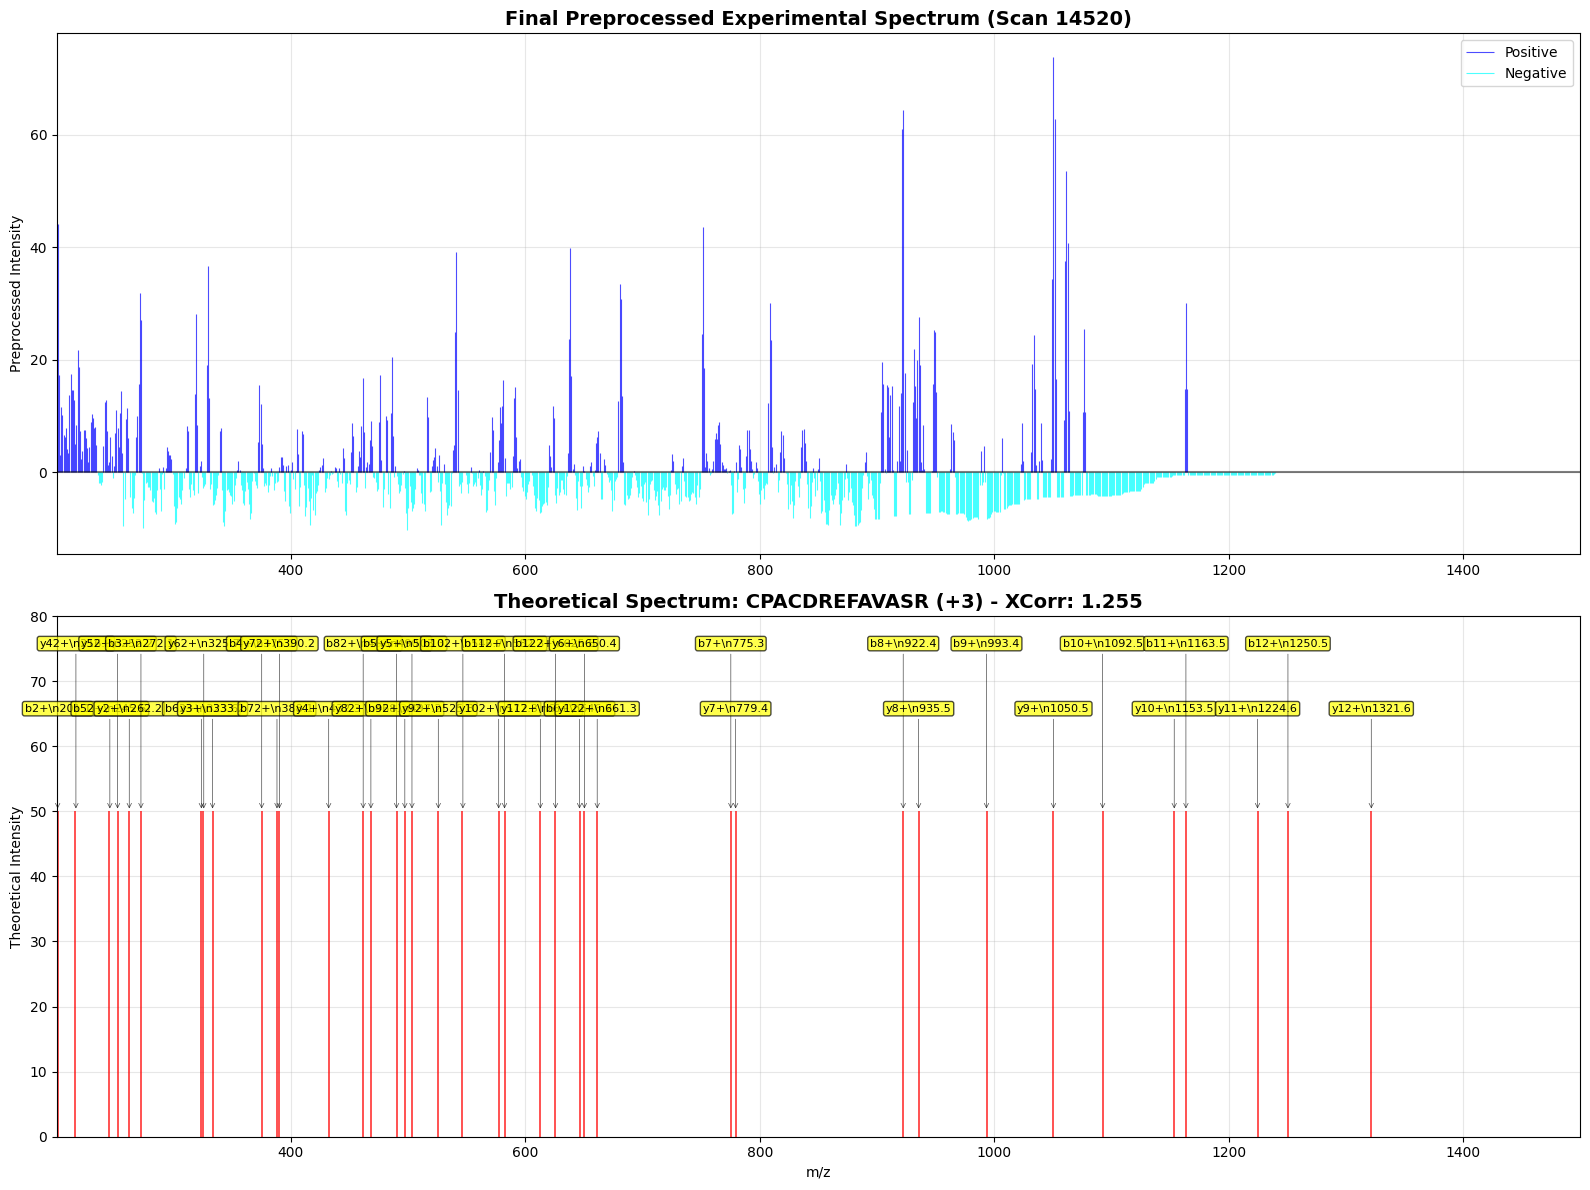


=== DETAILED ANALYSIS OF TOP PEPTIDE ===
Peptide sequence: CPACDREFAVASR
Charge state: +3
Theoretical m/z: 475.5518
XCorr score: 1.255
Protein ID: sp|Q5T619|ZN648_HUMAN

XCorr calculation details:
  Raw dot product: 12551.3
  Scaling factor: 0.005
  Final XCorr: 62.756

Peak matching analysis:
  Total theoretical peaks: 48
  Peaks with positive experimental signal: 20
  Matching percentage: 41.7%

Fragment ion summary:
  b-ions: 24 peaks
  y-ions: 24 peaks
  Total fragment ions: 48 peaks

Example fragment ions (first 5 of each type):
  b-ions:
    b1+: 104.02 m/z
    b12+: 52.51 m/z
    b2+: 201.07 m/z
    b22+: 101.04 m/z
    b3+: 272.11 m/z
  y-ions:
    y1+: 175.12 m/z
    y12+: 88.06 m/z
    y2+: 262.15 m/z
    y22+: 131.58 m/z
    y3+: 333.19 m/z

=== ANALYSIS COMPLETE ===
The plots show the final preprocessed experimental spectrum and the theoretical
spectrum of the best-scoring peptide with detailed b/y ion labels and m/z values.


In [12]:
# COMPREHENSIVE PEPTIDE SCORING AND THEORETICAL SPECTRUM ANALYSIS
print("\n=== COMPREHENSIVE PEPTIDE SCORING ANALYSIS ===")

# Read FASTA and generate all peptides for comprehensive scoring
print("Loading FASTA file for comprehensive analysis...")
fasta_file = 'uniprot_human_jan2025_yeastENO1_contam_ADpeps.fasta'
proteins = xcorr_engine.read_fasta(fasta_file)
print(f"Loaded {len(proteins)} proteins")

# Generate all peptides
print("Generating all peptides...")
all_peptides = []
for protein_id, sequence in proteins.items():
    peptides = xcorr_engine.digest_protein(sequence, protein_id)
    all_peptides.extend(peptides)

print(f"Generated {len(all_peptides)} total peptides")

# Find all peptides in the isolation window and score them
charge_states = [2, 3]
print(f"Scoring peptides in isolation window [{spectrum.isolation_window_lower:.4f} - {spectrum.isolation_window_upper:.4f}] m/z...")

scored_peptides = []
peptides_tested = 0

for peptide in all_peptides:
    for charge in charge_states:
        theoretical_mz = (peptide.mass + charge * xcorr_engine.proton_mass) / charge
        if spectrum.isolation_window_lower <= theoretical_mz <= spectrum.isolation_window_upper:
            # Generate theoretical spectrum
            theoretical_spectrum = xcorr_engine.generate_theoretical_spectrum(peptide, charge)
            
            # Calculate XCorr score
            xcorr_score = xcorr_engine.calculate_fast_xcorr(theoretical_spectrum, preprocessed_spectrum)
            
            scored_peptides.append({
                'peptide': peptide,
                'charge': charge,
                'theoretical_mz': theoretical_mz,
                'xcorr': xcorr_score,
                'theoretical_spectrum': theoretical_spectrum,
                'sequence': peptide.sequence,
                'protein_id': peptide.protein_id,
                'mass': peptide.mass
            })
            peptides_tested += 1

print(f"Scored {peptides_tested} peptides in isolation window")

# Sort by XCorr score (descending) and get top 5
scored_peptides.sort(key=lambda x: x['xcorr'], reverse=True)
top_peptides = scored_peptides[:5]

print(f"\n=== TOP 5 SCORING PEPTIDES ===")
for i, pep_data in enumerate(top_peptides, 1):
    print(f"{i}. {pep_data['sequence']} (+{pep_data['charge']})")
    print(f"   XCorr: {pep_data['xcorr']:.3f}")
    print(f"   Theoretical m/z: {pep_data['theoretical_mz']:.4f}")
    print(f"   Mass: {pep_data['mass']:.4f} Da")
    print(f"   Protein: {pep_data['protein_id']}")
    print()

if top_peptides:
    # Analyze the top scoring peptide in detail
    best_peptide = top_peptides[0]
    
    # Generate detailed theoretical spectrum information for labeling
    def generate_labeled_theoretical_spectrum(peptide_seq, charge):
        """Generate theoretical spectrum with detailed b/y ion information for labeling"""
        spectrum_data = np.zeros(xcorr_engine.num_bins)
        ion_labels = []
        
        # Create m/z array for spectrum
        mz_array = np.arange(xcorr_engine.mass_range[0], 
                           xcorr_engine.mass_range[0] + len(spectrum_data) * xcorr_engine.bin_width, 
                           xcorr_engine.bin_width)[:len(spectrum_data)]
        
        # Comet's precalculated masses
        nterm_proton = xcorr_engine.proton_mass  # 1.007276
        cterm_oh2_proton = xcorr_engine.h2o_mass + xcorr_engine.proton_mass  # 19.017841
        
        # Generate b ions (N-terminal fragments)
        b_mass = nterm_proton
        for i in range(len(peptide_seq) - 1):  # Exclude last residue
            b_mass += xcorr_engine.aa_masses.get(peptide_seq[i], 100.0)
            
            # Generate fragment charges 1+ and 2+ only
            for frag_charge in range(1, min(3, charge + 1)):
                mz = (b_mass + (frag_charge - 1) * xcorr_engine.proton_mass) / frag_charge
                if xcorr_engine.mass_range[0] <= mz <= xcorr_engine.mass_range[1]:
                    bin_idx = xcorr_engine.bin_mass(mz)
                    relative_bin_idx = bin_idx - xcorr_engine.bin_mass(xcorr_engine.mass_range[0])
                    if 0 <= relative_bin_idx < len(spectrum_data):
                        spectrum_data[relative_bin_idx] = 50.0
                        ion_labels.append({
                            'mz': mz,
                            'intensity': 50.0,
                            'label': f'b{i+1}{"+" if frag_charge == 1 else f"{frag_charge}+"}',
                            'bin_idx': relative_bin_idx
                        })
        
        # Generate y ions (C-terminal fragments)
        y_mass = cterm_oh2_proton
        for i in range(len(peptide_seq) - 1, 0, -1):  # Exclude first residue
            y_mass += xcorr_engine.aa_masses.get(peptide_seq[i], 100.0)
            y_ion_number = len(peptide_seq) - i
            
            # Generate fragment charges 1+ and 2+ only
            for frag_charge in range(1, min(3, charge + 1)):
                mz = (y_mass + (frag_charge - 1) * xcorr_engine.proton_mass) / frag_charge
                if xcorr_engine.mass_range[0] <= mz <= xcorr_engine.mass_range[1]:
                    bin_idx = xcorr_engine.bin_mass(mz)
                    relative_bin_idx = bin_idx - xcorr_engine.bin_mass(xcorr_engine.mass_range[0])
                    if 0 <= relative_bin_idx < len(spectrum_data):
                        spectrum_data[relative_bin_idx] = 50.0
                        ion_labels.append({
                            'mz': mz,
                            'intensity': 50.0,
                            'label': f'y{y_ion_number}{"+" if frag_charge == 1 else f"{frag_charge}+"}',
                            'bin_idx': relative_bin_idx
                        })
        
        return spectrum_data, ion_labels, mz_array
    
    # Generate labeled theoretical spectrum for the best peptide
    labeled_theoretical, ion_labels, mz_array = generate_labeled_theoretical_spectrum(
        best_peptide['sequence'], best_peptide['charge'])
    
    # Create comprehensive visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Panel 1: Final preprocessed experimental spectrum
    mask_exp = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
    positive_mask = mask_exp & (preprocessed_spectrum > 0)
    negative_mask = mask_exp & (preprocessed_spectrum < 0)
    
    if np.any(positive_mask):
        ax1.vlines(mz_binned[positive_mask], 0, preprocessed_spectrum[positive_mask], 
                   colors='blue', linewidth=0.8, alpha=0.7, label='Positive')
    if np.any(negative_mask):
        ax1.vlines(mz_binned[negative_mask], 0, preprocessed_spectrum[negative_mask], 
                   colors='cyan', linewidth=0.8, alpha=0.7, label='Negative')
    
    ax1.set_title(f'Final Preprocessed Experimental Spectrum (Scan {spectrum.scan_id})', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Preprocessed Intensity')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(plot_min_mz, plot_max_mz)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    if np.any(positive_mask) or np.any(negative_mask):
        ax1.legend()
    
    # Panel 2: Theoretical spectrum with detailed b/y ion labels
    mask_theo = (mz_array >= plot_min_mz) & (mz_array <= plot_max_mz) & (labeled_theoretical > 0)
    
    # Plot theoretical peaks
    ax2.vlines(mz_array[mask_theo], 0, labeled_theoretical[mask_theo], 
               colors='red', linewidth=1.2, alpha=0.8)
    
    # Add labels for b and y ions within the plot range
    labeled_peaks = []
    for ion_data in ion_labels:
        if plot_min_mz <= ion_data['mz'] <= plot_max_mz:
            labeled_peaks.append(ion_data)
    
    # Sort by m/z for better label placement
    labeled_peaks.sort(key=lambda x: x['mz'])
    
    # Add ion labels with alternating heights to avoid overlap
    label_height_offset = 5.0
    for i, ion_data in enumerate(labeled_peaks):
        # Alternate label heights to reduce overlap
        height_multiplier = 1.2 if i % 2 == 0 else 1.4
        label_y = ion_data['intensity'] * height_multiplier + label_height_offset
        
        # Add label with m/z value
        ax2.annotate(f"{ion_data['label']}\\n{ion_data['mz']:.1f}", 
                     xy=(ion_data['mz'], ion_data['intensity']),
                     xytext=(ion_data['mz'], label_y),
                     ha='center', va='bottom', fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', lw=0.5, color='black', alpha=0.7))
    
    ax2.set_title(f'Theoretical Spectrum: {best_peptide["sequence"]} (+{best_peptide["charge"]}) - XCorr: {best_peptide["xcorr"]:.3f}', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('m/z')
    ax2.set_ylabel('Theoretical Intensity')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(plot_min_mz, plot_max_mz)
    ax2.set_ylim(0, 80)  # Give extra space for labels
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis of the best peptide
    print(f"\n=== DETAILED ANALYSIS OF TOP PEPTIDE ===")
    print(f"Peptide sequence: {best_peptide['sequence']}")
    print(f"Charge state: +{best_peptide['charge']}")
    print(f"Theoretical m/z: {best_peptide['theoretical_mz']:.4f}")
    print(f"XCorr score: {best_peptide['xcorr']:.3f}")
    print(f"Protein ID: {best_peptide['protein_id']}")
    
    # Calculate raw dot product breakdown
    min_len = min(len(labeled_theoretical), len(preprocessed_spectrum))
    raw_dot_product = np.dot(labeled_theoretical[:min_len], preprocessed_spectrum[:min_len])
    
    print(f"\nXCorr calculation details:")
    print(f"  Raw dot product: {raw_dot_product:.1f}")
    print(f"  Scaling factor: 0.005")
    print(f"  Final XCorr: {raw_dot_product * 0.005:.3f}")
    
    # Count matching peaks
    matching_bins = np.sum((labeled_theoretical > 0) & (preprocessed_spectrum > 0))
    total_theoretical_peaks = np.sum(labeled_theoretical > 0)
    
    print(f"\nPeak matching analysis:")
    print(f"  Total theoretical peaks: {total_theoretical_peaks}")
    print(f"  Peaks with positive experimental signal: {matching_bins}")
    print(f"  Matching percentage: {matching_bins/total_theoretical_peaks*100:.1f}%")
    
    # Show fragment ion types found
    b_ions = [ion for ion in ion_labels if ion['label'].startswith('b')]
    y_ions = [ion for ion in ion_labels if ion['label'].startswith('y')]
    
    print(f"\nFragment ion summary:")
    print(f"  b-ions: {len(b_ions)} peaks")
    print(f"  y-ions: {len(y_ions)} peaks") 
    print(f"  Total fragment ions: {len(ion_labels)} peaks")
    
    # Show some example b and y ions
    print(f"\nExample fragment ions (first 5 of each type):")
    print("  b-ions:")
    for ion in b_ions[:5]:
        print(f"    {ion['label']}: {ion['mz']:.2f} m/z")
    print("  y-ions:")
    for ion in y_ions[:5]:
        print(f"    {ion['label']}: {ion['mz']:.2f} m/z")
    
else:
    print("No peptides found in isolation window for analysis.")

print("\n=== ANALYSIS COMPLETE ===")
print("The plots show the final preprocessed experimental spectrum and the theoretical")
print("spectrum of the best-scoring peptide with detailed b/y ion labels and m/z values.")